In [1]:
from keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = cifar10.load_data()


In [3]:
def noised_image(image,power_of_noise):
    noised_image = image + 3 * image.std() * np.random.random(image.shape) * power_of_noise
    return noised_image


In [4]:
x_train = x_train.astype('float32') / 255.
x_test  = x_test .astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 32, 32, 3))
x_test  = np.reshape(x_test,  (len(x_test),  32, 32, 3))

In [5]:
import random

#create noised train dataset
train_noise = []

for i in range(x_train.shape[0]):
    power = random.randint(10,20)
    power = power / 100.
    img = noised_image(x_train[i], power)
    train_noise.append(img)

train_noise = np.array(train_noise)

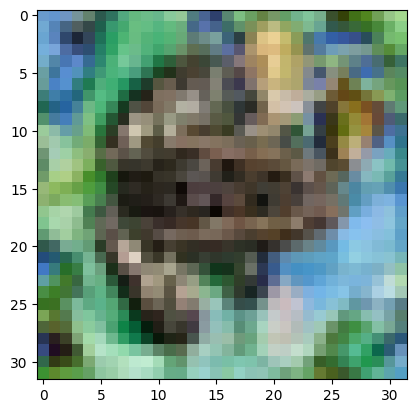

In [6]:
plt.imshow(x_train[200])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


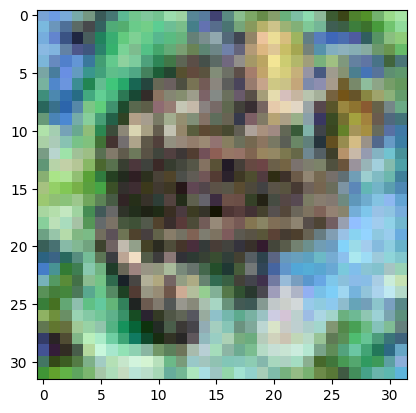

In [7]:
plt.imshow(train_noise[200])

In [8]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Activation
from keras.models import Model

In [9]:
def create_conv_ae():

    # encoder
    input_img = Input(shape=(32, 32, 3))

    conv1_1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    
    conv1_2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1_1)
    pool1 = MaxPooling2D((2, 2), padding='same')(conv1_2)

    conv2_1 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2_2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2_1)
    pool2 = MaxPooling2D((2, 2), padding='same')(conv2_2)

    conv3_1 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    encoded = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3_1)
    enc_dim = encoded.shape[1:]

    encoder = Model(input_img, encoded, name = 'encoder')

    # decoder
    input_encoded = Input(shape=enc_dim)

    conv4_1 = Conv2D(128, (3, 3), activation='relu', padding='same')(input_encoded)
    conv4_2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4_1)
    up1 = UpSampling2D((2, 2), interpolation='bilinear')(conv4_2)

    conv5_1 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
    conv5_2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5_1)
    up2 = UpSampling2D((2, 2), interpolation='bilinear')(conv5_2)

    conv6_1 = Conv2D(32, (3, 3), activation='relu', padding='same')(up2)
    conv6_2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv6_1)
    conv6_3 = Conv2D(3, (1, 1), padding='same')(conv6_2)
    decoded = Activation('sigmoid')(conv6_3)

    decoder = Model(input_encoded, decoded, name = 'decoder')

    #autoencoder
    autoencoder = Model(input_img, decoder(encoder(input_img)), name = 'autoencoder')

    return encoder, decoder, autoencoder

In [10]:
encoder, decoder, autoencoder = create_conv_ae()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [11]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 encoder (Functional)        (None, 8, 8, 128)         287008    
                                                                 
 decoder (Functional)        (None, 32, 32, 3)         433699    
                                                                 
Total params: 720,707
Trainable params: 720,707
Non-trainable params: 0
_________________________________________________________________


In [12]:
#create noised test dataset
test_noise = []

for i in range(x_test.shape[0]):
    power = random.randint(10,25)
    power = power / 100.
    img = noised_image(x_test[i], power)
    test_noise.append(img)

test_noise = np.array(test_noise)
test_noise.shape

(10000, 32, 32, 3)

In [ ]:
autoencoder.fit(x=train_noise, y=x_train,
                epochs=20,
                batch_size=64,
                shuffle=True,
                validation_data=(test_noise, x_test))

Epoch 1/20
574/782 [=====================>........] - ETA: 2:00 - loss: 0.5878

In [9]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

def plot_images(*args):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    
    plt.figure(figsize=(2*n, 2*len(args)))
    for j in range(n):
        for i in range(len(args)):
            ax = plt.subplot(len(args), n, i*n + j + 1)
            plt.imshow(args[i][j])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()

In [ ]:
n = 10

imgs = x_test[:n]
encoded_imgs = encoder.predict(imgs, batch_size=n)

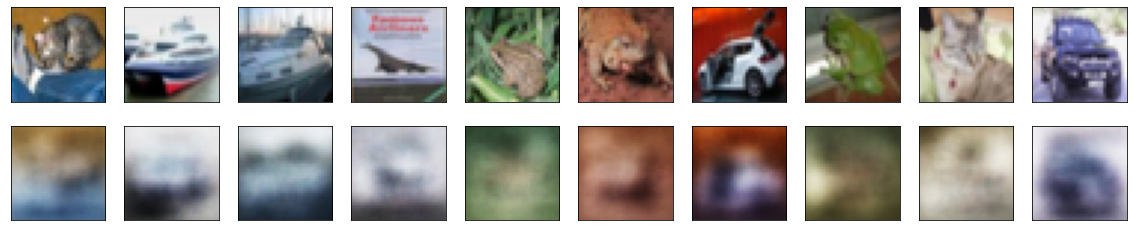

In [11]:
decoded_imgs = decoder.predict(encoded_imgs, batch_size=n)
plot_images(imgs, decoded_imgs)

In [83]:
def noised_image(image,power_of_noise):
    image = image / 255.
    noised_image = image + 3 * image.std() * np.random.random(image.shape)*power_of_noise
    return noised_image


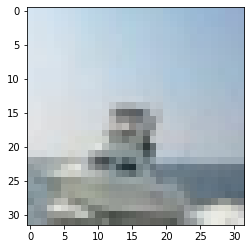

In [89]:
plt.imshow(x_train[100])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


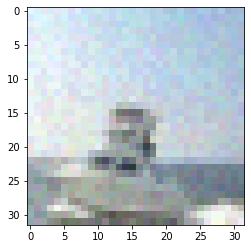

In [86]:
plt.imshow(noised_image(x_train[100], 0.2))


## Test task: 
### "Denoising Autoencoder"


1. You should create convolutional denoising autoencoder, which will remove noise from the images from CIFAR10 dataset.
2. Develop a function that takes as input noised image from CIFAR10 dataset and returns reconstructed one.
